In [170]:
# ! pip install xgboost

In [171]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import xgboost as xgb

In [172]:
dataset_path = './data/Problem3.csv'
data_df = pd.read_csv(dataset_path)
data_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,4.468204,26.2,94.3,1.808289,8.2,51,6.7,False,0.0
1,7,4,oct,tue,4.517431,35.4,669.1,2.041220,18.0,33,0.9,False,0.0
2,7,4,oct,sat,4.517431,43.7,686.9,2.041220,14.6,33,1.3,False,0.0
3,8,6,mar,fri,4.529368,33.3,77.5,2.302585,8.3,97,4.0,True,0.0
4,8,6,mar,sun,4.503137,51.3,102.2,2.360854,11.4,99,1.8,False,0.0


### label encoding
- xài OrdinalEncoder để chuyển biến bool
- xài map để chuyển date và tháng đúng

In [173]:
# # mã hóa labels, ngày , tháng
month_order = {'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6,
               'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12}

day_order = {'mon': 1, 'tue': 2, 'wed': 3,
             'thu': 4, 'fri': 5, 'sat': 6, 'sun': 7}
ordinal_encoder = OrdinalEncoder()
# categorical_cols = data_df.select_dtypes(include=['category', 'object', 'bool']).columns.to_list()

data_df[['rain']] = ordinal_encoder.fit_transform(data_df[['rain']])

data_df['month'] = data_df['month'].map(month_order)
data_df['day'] = data_df['day'].map(day_order)


data_df.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,3,5,4.468204,26.2,94.3,1.808289,8.2,51,6.7,0.0,0.0
1,7,4,10,2,4.517431,35.4,669.1,2.041220,18.0,33,0.9,0.0,0.0
2,7,4,10,6,4.517431,43.7,686.9,2.041220,14.6,33,1.3,0.0,0.0
3,8,6,3,5,4.529368,33.3,77.5,2.302585,8.3,97,4.0,1.0,0.0
4,8,6,3,7,4.503137,51.3,102.2,2.360854,11.4,99,1.8,0.0,0.0


In [174]:
x = data_df.iloc[:, :-1]
y = data_df.iloc[:, -1]

### feature engineering

In [175]:
def make_mi_scores(x: pd.DataFrame, y, discrete_features):
    mi_scores = mutual_info_regression(
        x, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=x.columns)
    mi_scores = mi_scores.sort_values(ascending=False)

    return mi_scores

In [176]:
mi_scores = make_mi_scores(x, y, [True, True, True, True, False,False,False,False,False, False, False, True])
mi_scores

month    0.093460
temp     0.088356
DMC      0.067192
DC       0.057708
ISI      0.047823
RH       0.036701
FFMC     0.009145
wind     0.006901
rain     0.001434
X        0.000000
Y        0.000000
day      0.000000
Name: MI Scores, dtype: float64

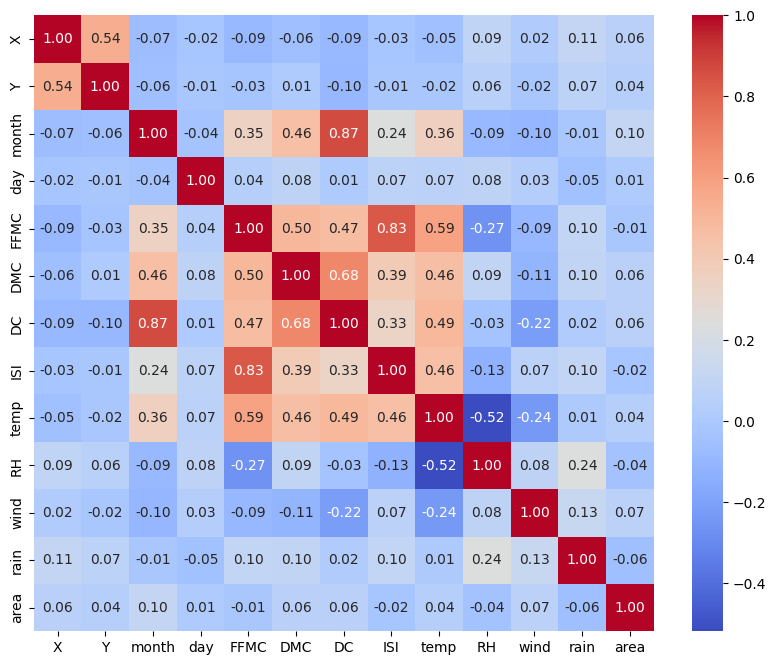

In [177]:
correlation_matrix = data_df.corr()
# Vẽ heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

### chia train-test

In [178]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y, 
    test_size=0.3,
    random_state=7
)

xg_reg = xgb.XGBRegressor(learning_rate = 0.01, n_estimators = 102, max_depth = 3, seed = 42)

xg_reg.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=102, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [179]:
pred = xg_reg.predict(x_test)

In [180]:
mae = mean_absolute_error (y_test, pred)
mse = mean_squared_error (y_test, pred)

print('Evaluation results on test set:')
print(f'Mean Absolute Error :{mae}')
print(f'Mean Squared Error : {mse}')

Evaluation results on test set:
Mean Absolute Error :1.151136213202416
Mean Squared Error : 1.8834708202370707
